<a href="https://colab.research.google.com/github/ssegovba/identifying-deforestation/blob/main/notebooks/eda_satellite_imageryf.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Exploratory Data Analysis on Amazon Rainforest Satellite Imagery Data
by *Santiago Segovia*

One of the main issues when trying to build supervised ML models is the lack of labeled data. These are required to train the algorithms to perform the task one aims to solve in previously-unseen data.

This notebook performs an initial check of the data from the [Kaggle challenge Planet: Understanding the Amazon from Space](https://www.kaggle.com/competitions/planet-understanding-the-amazon-from-space). It contains satellite imagery labeled data that will be used for an ML classification model to track deforestation in the Amazon Rainforest.

## I. Initial Set-up

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import cv2
from matplotlib import pyplot as plt
%matplotlib inline

from google.colab import drive

In [2]:
# Mount GDrive
drive.mount("/content/drive", force_remount=True)

Mounted at /content/drive


In [30]:
# Number of train images (missing some files. In Kaggle EDA there are 40,479)
! ls "/content/drive/Shareddrives/computer-vision-project/Data/Unzipped/planet/planet/train-jpg" -1 | wc -l

37620


In [31]:
# Number of test images (same as in Kaggle)
! ls "/content/drive/Shareddrives/computer-vision-project/Data/Unzipped/planet/planet/test-jpg" -1 | wc -l

40669


## II. The Data

The provided training data comes from imagery of the Amazon basin captured by Planet's Flock 2 satellites between January 1st, 2016, and February 1st, 2017. The images contain the visible red (R) , green (G) , and blue (B) and near-infrared (NIR) bands. The **labels** include several phenomena of interest in the Amazon rainforest basin that are divided into atmospheric conditions, common land cover/use, and rare land cover/use. Each image will have one and potentially more than one atmospheric label and zero or more common or rare labels.

## II.a Labels

We have roughly the same number of images for train/test. We load the file that has the labels of each one of the train images. For this iamges, a single one could be assigned to multiple categories. For instance, `train_1` image is classified as agriculture, clear, primary, and water:

In [3]:
# Load data
data_path = "/content/drive/Shareddrives/computer-vision-project/Data/Unzipped/planet/planet/"
labels_df = pd.read_csv(data_path + "train_classes.csv")

In [4]:
labels_df.shape

(40479, 2)

In [5]:
labels_df.head(10)

,image_name,tags
0,train_0,haze primary
1,train_1,agriculture clear primary water
2,train_2,clear primary
3,train_3,clear primary
4,train_4,agriculture clear habitation primary road
5,train_5,haze primary water
6,train_6,agriculture clear cultivation primary water
7,train_7,haze primary
8,train_8,agriculture clear cultivation primary
9,train_9,agriculture clear cultivation primary road


We check all the different labels in the dataset and their distribution:

In [6]:
labels = labels_df['tags'].apply(lambda x: x.split(' '))

In [7]:
cnt_labels = {}
for item in labels:
  for label in item:
    cnt_labels[label] = cnt_labels.get(label, 0) + 1

In [8]:
num_labels = pd.DataFrame.from_dict(cnt_labels,  orient='index').reset_index(). \
  rename(columns={"index": "label", 0: "count"}).sort_values('count', ascending=False)

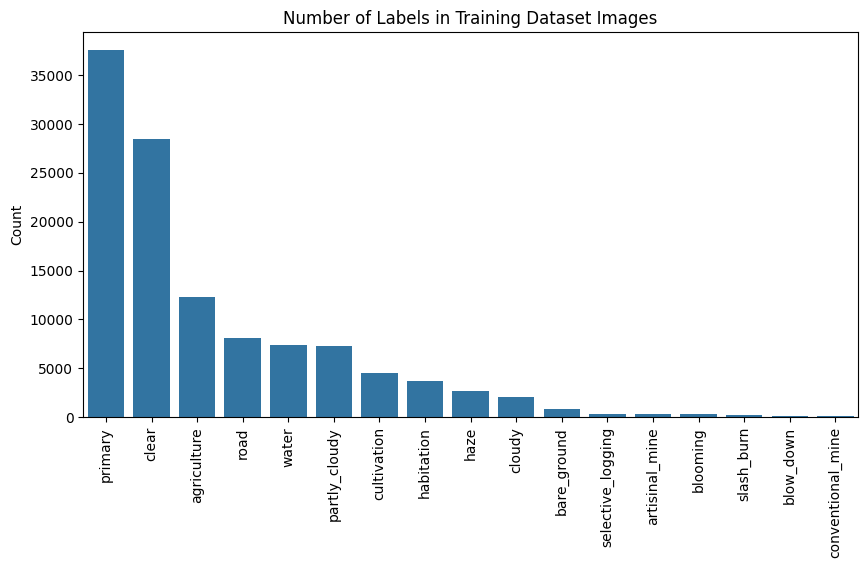

In [9]:
plt.figure(figsize=(10, 5))
sns.barplot(num_labels, x="label", y="count")

plt.xlabel("")
plt.ylabel("Count")
plt.xticks(rotation=90)
plt.title("Number of Labels in Training Dataset Images")
plt.show()

As we can see from the plot, the vast majority of images have `primary` tags and `clear`.

## II.b Plotting Images

We begin by checking the characteristics of our images. To do this we use `cv2` library as it is more efficient than `skimage`. As we can see, the images only have three channels (RGB) and their size is 256 x 256:

In [25]:
img_path = f"{data_path}train-jpg/train_1.jpg"
img = cv2.imread(img_path)

In [26]:
img.ndim

3

In [27]:
img.shape

(256, 256, 3)

Plotting some samples of the train data set let us appreciate both the images and their respective labels:

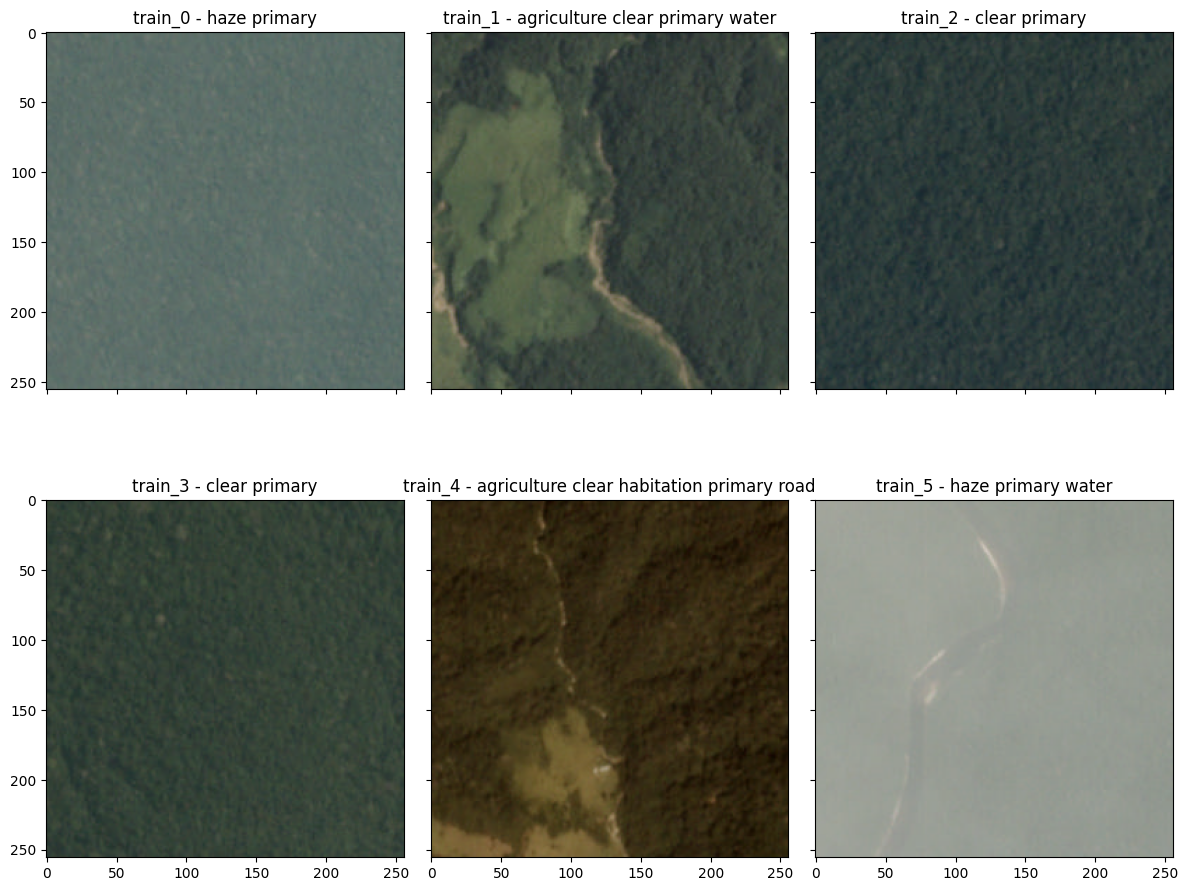

In [17]:
# Setup the style directly without the need for an intermediate dictionary
plt.rc('axes', grid=False)

# Create a 2x3 grid of subplots with shared x and y axes, and set the figure size
fig, axes = plt.subplots(2, 3, sharex='col', sharey='row', figsize=(12, 10))
axes = axes.flatten()  # Flatten the axes array for easier indexing

# Ensure that you do not attempt to plot more images than you have subplots
num_images = len(labels_df[:6].values)
assert num_images <= 6, "Attempting to plot more images than subplots available"

# Loop over the first 6 entries of labels_df with automatic indexing via enumerate
for idx, (filename, label) in enumerate(labels_df[:6].values):
    # Load the image using cv2
    img_path = f"{data_path}train-jpg/{filename}.jpg"
    img = cv2.imread(img_path)

    # Check if the image is loaded properly
    if img is None:
        print(f"Failed to load image at: {img_path}")
        continue

    # Convert BGR to RGB for plotting
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

    # Display the image on the corresponding subplot
    axes[idx].imshow(img)

    # Set the title for each subplot
    axes[idx].set_title(f"{filename} - {label}")

# Disable axes not used if there are any (e.g., if less than 6 images are to be plotted)
if len(labels_df[:6].values) < 6:
    for ax in axes[len(labels_df[:6].values):]:
        ax.axis('off')

# Show the plot
plt.tight_layout()  # Adjust layout to prevent overlap
plt.show()